# Introduction

**<font size="4">Evaluation</font>**
<br>

In real life, physicians diagnose brain tumors through X-ray images with naked eyes. However, Deep Learning can help diagnosis and may be more accurate because Deep Learning can separate image features into tiny pieces that the naked eye could not make. In addition to hospital diagnosis, the class 1 precision should be nearly 100%, or there would be a misdiagnosis in healthy patients, resulting in unnecessary cancer treatment.
<br>


**<font size="4">Purpose</font>**
<br>

Create a Deep Learning Convolutional Neural Network(CNN) model that can predict brain tumors based on provided 4600 labelled brain X-ray images

# Material and Methods

**<font size="4">Data</font>**
<br>

The brain images are gathered by Preet Viradiya and published on Kaggle: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset?sort=votes
<br>


**<font size="4">Features</font>**
1. **Healthy Brain (class 0)** X-Ray image
2. **Tumor Brain (class 1)** X-Ray image
<br>


**<font size="4">Modelling</font>**
<br>
Two main methods were implemented: (1.) own Convolutional Neural Networks (2.) Transfer Learning (Mobile Net V3 large)





## Importing Libraries/Tools

In [1]:
#File Handling and Manipulating Tools
from pathlib import Path
import os
import datetime


#Exploratory Data Aalysis and Graphing Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import seaborn as sns
import random
%load_ext tensorboard

#Deep Learning Tools- Tensorflow and Keras
import tensorflow as tf
import tensorflow_hub as hub

import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

#Model Evaluation 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## Setting Parameters Values

In [2]:
BATCH_SIZE = 16
IMG_SIZE = 224
CHANNELS = 1
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)
NUM_EPOCHS = 100 

## Reading the Images into Jupyter Notebook

In [3]:
MAINDIR = 'brain-disease/Brain Tumor Data Set/Brain Tumor Data Set/'

### Checking Image File Type Validation on Deep Learning Training

In [4]:
invalid_data =[]
data = []
data_dir = "brain-disease/Brain Tumor Data Set/Brain Tumor Data Set/"
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png",".jpg"]


for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() not in img_type_accepted_by_tf:
        invalid_data.append(str(filepath))
        
len(invalid_data)

96

In [5]:
invalid_data = [str.replace("\\","/") for str in invalid_data]

###  Creating Class and Directory DataFrame for Valid Images File

In [6]:
subfile = ["Brain Tumor", "Healthy"]

def load_file(data_dir):
    data =[]
    for label in subfile: 
        path = os.path.join(data_dir , label)
   
        for img_name in os.listdir(path):
            if label == subfile[0]:
                data.append((path+"/"+img_name, 1))
            elif label ==subfile[1]:
                data.append((path+"/"+img_name, 0))
                
    data = pd.DataFrame(data)
    data.columns = ["Filename","Condition"]
    
    
    return(data)

In [7]:
all_data = load_file(MAINDIR)
len(all_data)
all_data = all_data.loc[-all_data['Filename'].isin(invalid_data)]
all_data.reset_index(drop=True, inplace =True)

In [8]:
print("Total images:" , len(all_data))
print(all_data["Condition"].value_counts())

Total images: 4506
1    2426
0    2080
Name: Condition, dtype: int64


# Results - Visualization 

## Pie Chart for Tumor and Healthy Brain X-ray Image

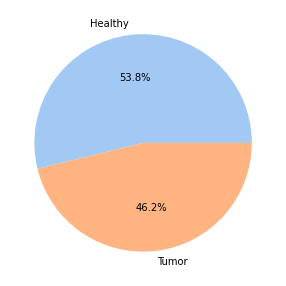

In [9]:
fig, ax= plt.subplots(figsize=(5,5))
colors = sns.color_palette('pastel')
ax.pie(data=all_data, x= all_data["Condition"].value_counts(),labels = ["Healthy","Tumor"], colors = colors, autopct='%.1f%%');

## Random 9 Images with Healthy and Tumor Labels

In [10]:
def show_9_random_images(data):
    plt.figure(figsize=(15,10))
    for num in range(9):
        ax = plt.subplot(4, 3, num+1)
        n = random.randint(0, len(data["Filename"]))
        img = plt.imread(data["Filename"][n])
        plt.imshow(img)
        
        if data["Condition"][n] == 1:
            titlname = subfile[0]
            plt.title(titlname, color ="red")
        else:
            titlname = subfile[1]
            plt.title(titlname, color ="green")
            
        plt.axis('off')
        plt.tight_layout(pad = 0.01)

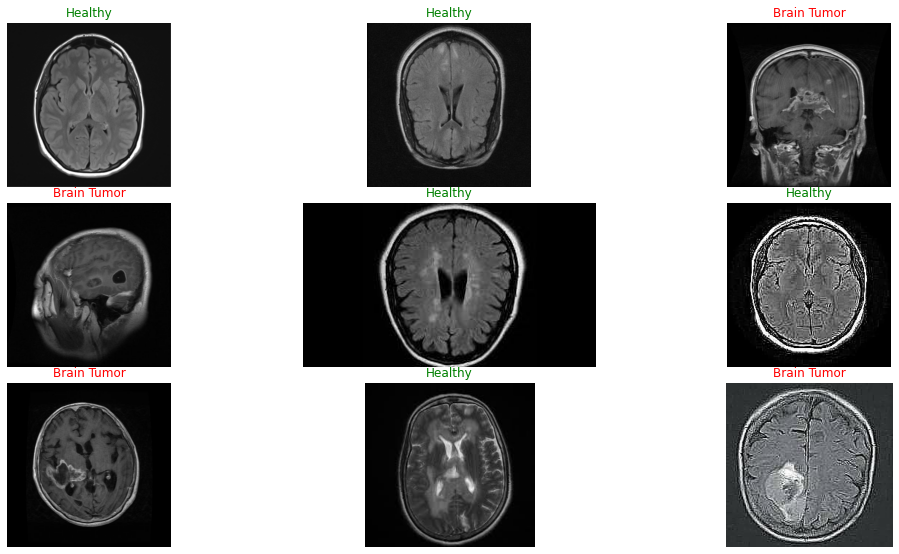

In [11]:
show_9_random_images(all_data)

# Results - Deep Learning

## Data Preprocessing

### Converting Tumor Class Labels into Boolean Labels

In [12]:
Condition = np.array([0,1])
labels = all_data["Condition"].to_numpy()
boolean_labels = [label == Condition for label in labels]

In [13]:
X = all_data["Filename"]
y = boolean_labels

###  Spliting Images into Train, Valid and Test Groups

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=5)    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=5) # 0.2*0.9 ~= 0.20
print(len(X_train), len(y_train), len(X_val), len(y_val), len(X_test),  len(y_test))

3162 3162 893 893 451 451


In [15]:
def test_5_random_shape(data):
    for i in range(5):
        n = random.randint(0, len(all_data["Filename"]))
        image = imread(X[n])
        print(image.shape) #height, width, color channel

test_5_random_shape(data = all_data)

(340, 314, 3)
(221, 228, 3)
(225, 225, 3)
(348, 287, 3)
(201, 173, 3)


### Reading, Decoding, Normalizing, and Resizing Image File

In [16]:
def process_images(image_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

In [17]:
def image_label(image_path, label):
    image = process_images(image_path)
    return image, label

## CNN Model

### Building CNN Model Layers

In [18]:
def create_model(input_shape = INPUT_SHAPE):
    
    model = keras.Sequential()
    model.add(InputLayer(INPUT_SHAPE))
    model.add(Conv2D(32,(3,3), activation="relu", padding="same",strides = 2, kernel_initializer = "he_uniform"))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation="relu", padding="same",strides = 2, kernel_initializer = "he_uniform"))
    model.add(Dropout(rate=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation="relu", padding="same",strides = 2, kernel_initializer = "he_uniform"))
    model.add(Dropout(rate=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation="relu", padding="same",strides = 2, kernel_initializer = "he_uniform"))
    model.add(Dropout(rate=0.2))
    model.add(BatchNormalization())
   
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu', kernel_initializer = "he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(64, activation='relu', kernel_initializer = "he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(2, activation="sigmoid"))

    model.compile(
       loss=tf.keras.losses.BinaryCrossentropy(),
       optimizer=tf.keras.optimizers.Adam(),
       metrics=["accuracy"]
    )
    
    return model

#### Model Layers Summary

In [19]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

###  Creating Data Batches

In [20]:
def create_batch(X, y=None, batch_size= BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_images).batch(BATCH_SIZE)
        return data_batch

    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        data_batch = data.map(image_label).batch(BATCH_SIZE)
        return data_batch

    else:

        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        data = data.shuffle(buffer_size = len(X)) 
        data_batch = data.map(image_label).batch(BATCH_SIZE)
        return data_batch

In [21]:
tensor_train_data = create_batch(X_train, y_train)
tensor_val_data   = create_batch(X_val, y_val,valid_data=True)
tensor_test_data  = create_batch(X_test, y_test,test_data=True)
tensor_train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))>

#### Visualizing Data Batches

In [22]:
def show_16_images(images,labels):

  plt.figure(figsize=(10,10))
  for i in range(16): 
    ax = plt.subplot(4,4,i+1) 
    plt.imshow(images[i], cmap='gray') 
    plt.axis("off")

(16, 16)

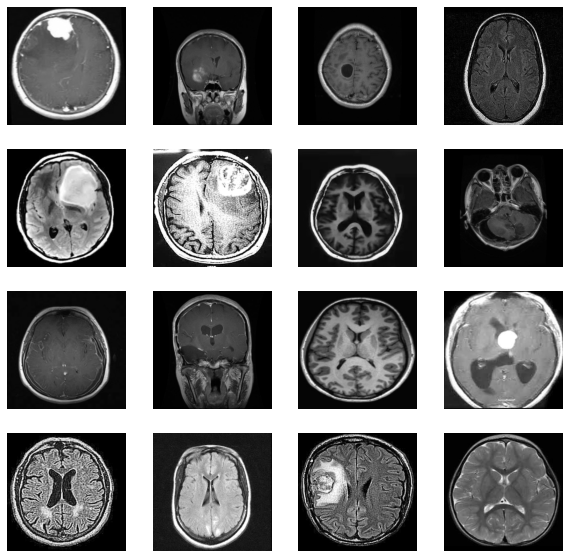

In [23]:
train_images, train_labels =next(tensor_train_data.as_numpy_iterator())
show_16_images(train_images, train_labels)
len(train_images), len(train_labels)

all the images are sucessfully loaded and processed (resize...etc)

### Callback Function

#### Early Stopping 

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=5, restore_best_weights=True)

#### Tensorboard Callback - Logs Records

In [25]:
#create a function to build a tensorboard callback
def create_tensorboard_callback():
  logdir = os.path.join(r"C:\Users\dakfo\MLProject\sample_project_1\brain-logs",
                        #getting a log file to track the history everytime
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

## Trainng CNN Model

In [26]:
def train_model():

  #create model
  model = create_model()

  #create new tensorboard session everythime 
  tensorboard = create_tensorboard_callback()

  #fit the model and store the learning curve to the history too
  history = model.fit(x= tensor_train_data,
            epochs= NUM_EPOCHS,
            validation_data = tensor_val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model, history

In [27]:
model, history = train_model() 

Epoch 1/100
198/198 [==============================] - 8s 20ms/step - loss: 0.6278 - accuracy: 0.7343 - val_loss: 0.5133 - val_accuracy: 0.7738
Epoch 2/100
198/198 [==============================] - 3s 18ms/step - loss: 0.3772 - accuracy: 0.8463 - val_loss: 0.4336 - val_accuracy: 0.8052
Epoch 3/100
198/198 [==============================] - 4s 18ms/step - loss: 0.2762 - accuracy: 0.8918 - val_loss: 0.2648 - val_accuracy: 0.8813
Epoch 4/100
198/198 [==============================] - 4s 18ms/step - loss: 0.2289 - accuracy: 0.9162 - val_loss: 0.1562 - val_accuracy: 0.9462
Epoch 5/100
198/198 [==============================] - 4s 18ms/step - loss: 0.1879 - accuracy: 0.9285 - val_loss: 0.1670 - val_accuracy: 0.9474
Epoch 6/100
198/198 [==============================] - 4s 18ms/step - loss: 0.1443 - accuracy: 0.9459 - val_loss: 0.1044 - val_accuracy: 0.9642
Epoch 7/100
198/198 [==============================] - 4s 18ms/step - loss: 0.1365 - accuracy: 0.9541 - val_loss: 0.1231 - val_accuracy:

### Validation Loss and Accuracy Score 

In [28]:
test_loss, test_score = model.evaluate(tensor_val_data)
print(f"the test loss of the test data is: {test_loss}")
print(f"the accuracy score of the test data is: {test_score}")

56/56 [==============================] - 0s 8ms/step - loss: 0.0676 - accuracy: 0.9810
the test loss of the test data is: 0.06764589250087738
the accuracy score of the test data is: 0.9809630513191223


### Predicting Test Group

In [29]:
preds = model.predict(tensor_test_data)
preds = np.argmax(preds, axis=-1)

29/29 [==============================] - 0s 9ms/step


In [30]:
y_test = [n.astype(int) for n in y_test]
y_test = np.argmax(y_test, axis=-1)

## Test Results 

### Confusion Matrix

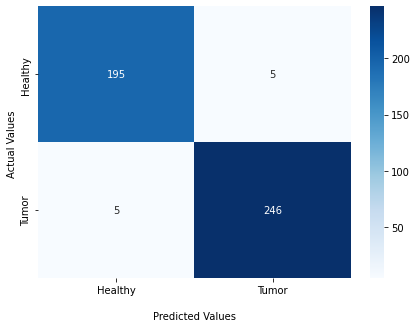

In [31]:
cm  = confusion_matrix(y_test, preds)
plt.figure(figsize=(7,5))

ax = sns.heatmap(cm, annot = True, cmap='Blues',fmt='.3g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Healthy','Tumor'])
ax.yaxis.set_ticklabels(['Healthy','Tumor'])

plt.show()

### Accuracy and Classification Report 

In [32]:
print("Accuracy of the Model:",accuracy_score(y_test, preds)*100,"%")
print(classification_report(y_test, preds))

Accuracy of the Model: 97.78270509977827 %
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.98      0.98      0.98       251

    accuracy                           0.98       451
   macro avg       0.98      0.98      0.98       451
weighted avg       0.98      0.98      0.98       451



### Learninig Curve

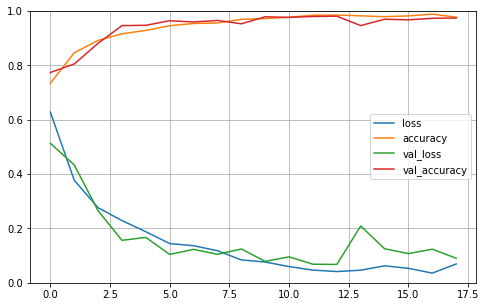

In [33]:
pd.DataFrame(history.history).plot(figsize =(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Results- Transfer Learning : Imagenet Classification with MobileNet V3 large

In [34]:
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"
CHANNELS = 3
INPUT_SHAPE = [None, IMG_SIZE,IMG_SIZE, CHANNELS]
OUTPUT_SHAPE = len(subfile)

## Building Model

In [74]:
 def create_model (input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
   print("Building model with:", MODEL_URL)

   #setup the model layers
   model = tf.keras.Sequential([
     hub.KerasLayer(MODEL_URL),#trainable=True #arguments=dict(batch_norm_momentum=0.997; batch_norm_momentum = decay coefficient
     tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="sigmoid") 
   ])
   
   #Compile the model
   model.compile(
       loss=tf.keras.losses.BinaryCrossentropy(),
       optimizer=tf.keras.optimizers.Adam(),
       metrics=["accuracy"]
   )

   #Build the model
   model.build(INPUT_SHAPE)

   return model

In [75]:
model = create_model() 

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5


In [76]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 1001)              5508713   
                                                                 
 dense_13 (Dense)            (None, 2)                 2004      
                                                                 
Total params: 5,510,717
Trainable params: 2,004
Non-trainable params: 5,508,713
_________________________________________________________________


In [77]:
#create another logs file so do not bother the previous one
def create_tensorboard_callback():
  logdir = os.path.join(r"C:\Users\dakfo\MLProject\sample_project_1\brain-logs-2",
                        
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

The `process_image` and `create_batch` should be the same as upper part, but for easy reading, they are showing down below

In [78]:
def process_images(image_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

In [79]:
def create_batch(X, y=None, batch_size= BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_images).batch(BATCH_SIZE)
        return data_batch

    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        data_batch = data.map(image_label).batch(BATCH_SIZE)
        return data_batch

    else:

        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        data = data.shuffle(buffer_size = len(X)) 
        data_batch = data.map(image_label).batch(BATCH_SIZE)
        return data_batch

In [80]:
tensor_train_data = create_batch(X_train, y_train)
tensor_val_data = create_batch(X_val, y_val,valid_data=True)
tensor_test_data = create_batch(X_test, y_test,test_data=True)

In [81]:
model, history = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5
Epoch 1/100
198/198 [==============================] - 17s 37ms/step - loss: 0.3698 - accuracy: 0.8441 - val_loss: 0.2492 - val_accuracy: 0.9227
Epoch 2/100
198/198 [==============================] - 7s 33ms/step - loss: 0.2114 - accuracy: 0.9292 - val_loss: 0.2107 - val_accuracy: 0.9351
Epoch 3/100
198/198 [==============================] - 7s 33ms/step - loss: 0.1747 - accuracy: 0.9415 - val_loss: 0.1959 - val_accuracy: 0.9295
Epoch 4/100
198/198 [==============================] - 7s 34ms/step - loss: 0.1503 - accuracy: 0.9513 - val_loss: 0.1701 - val_accuracy: 0.9373
Epoch 5/100
198/198 [==============================] - 7s 34ms/step - loss: 0.1380 - accuracy: 0.9570 - val_loss: 0.1558 - val_accuracy: 0.9451
Epoch 6/100
198/198 [==============================] - 7s 33ms/step - loss: 0.1231 - accuracy: 0.9551 - val_loss: 0.1497 - val_accuracy: 0.9395
Epoch 7/100
198/198 [===============

## Test Results

In [82]:
preds = model.predict(tensor_test_data)
preds = np.argmax(preds, axis=-1)

29/29 [==============================] - 1s 23ms/step


### Confusion Matrix

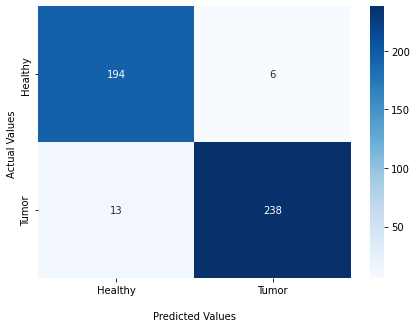

In [83]:
cm  = confusion_matrix(y_test, preds)
plt.figure(figsize=(7,5))

ax = sns.heatmap(cm, annot = True, cmap='Blues',fmt='.3g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Healthy','Tumor'])
ax.yaxis.set_ticklabels(['Healthy','Tumor'])

plt.show()

### Accuracy and Classification Report 

In [84]:
print("Accuracy of the Model:",accuracy_score(y_test, preds)*100,"%")
print(classification_report(y_test, preds))

Accuracy of the Model: 95.78713968957871 %
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       200
           1       0.98      0.95      0.96       251

    accuracy                           0.96       451
   macro avg       0.96      0.96      0.96       451
weighted avg       0.96      0.96      0.96       451



### Learninig Curve

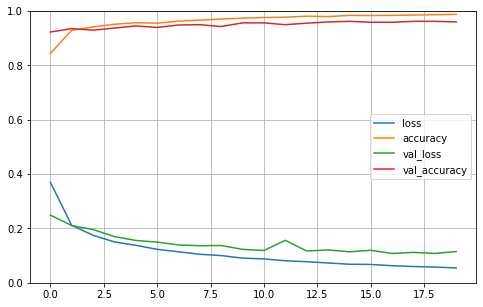

In [85]:
pd.DataFrame(history.history).plot(figsize =(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Conclusion

**<font size="4">In two CNN models' training ((Model 1) own CNN model and (Model 2) Transfer Learning [MobileNet V3 large])</font>**

**<font size="3">Statistics:</font>**
<br>

With both models on **1000 patients** prediction (class 0:class 1 = 53.8%:46.2%):
1. **95+%** of patients can predict into the correct class 
* Model 1 got better accuracy (98%)
2. **Class 1 recall is 95+%**, less likely to uncover Pneumonia patients
* Model 1 got better class 1 recall (98%)
3. **The class 0 recall is 97%**, both models got high precision and recall on each class

**<font size="3">Train Loss and Validation Loss:</font>**
1. In both models, the Train Loss and Validation Loss both reduced throughout the time. However, **model 2 has a more stable improvement in decreasing the loss function** (model 1 fluctuates)
2. Model 2 is overfitting the instances; the training accuracy is always higher than validation accuracy. Model 1 does not overfit the data, **model 1 regularized better and got higher accuracy**


**<font size="3">Overall:</font>**
1. The **two models shared the same pattern** but they are still differ
2. Model 2 can detect 95% of brain tumor patients, but model 1 can detect 98%
3. After stating patients have a brain tumor, all model has a 98% of chance being true
4. Model 2 has a better learning curve on loss reduction, but it is a bit overfitting

# Discussion

**<font size="3">Reason:</font>**
1. Model 2 has more layers and is pre-trained. It can capture more features into detail so it can steadily decrease the loss more effectively; however, it also leads to overfitting
2. Model 1 has not been trained before, the hidden layers are also not up for five layers, and the instances are less than 5000. Therefore, even if the results have higher accuracy than model 2, the loss function may not be optimized.

**<font size="4">Interpretation:</font>**
<br>


We should not prefer one model to the other in the current two models. Utilizing Machine Learning Soft Voting techniques can be a better way to make the decision. Soft Voting method: **Sum all models predicted possibilities together and make the final decision**. However, it is better to optimize both models first since we can do something to improve the model rather than make a rash decision now.

**<font size="4">To Improve the CNN Models Inference:</font>**

**<font size="3">Improve Model 1:</font>**
1. Increase the number of hidden layers or size of the hidden layers 
2. Try out `activation = elu` or `activation = selu`, since they are relu variants that can calculate negative values, which in some models can potentially perform better 

**<font size="3">Improve Model 2:</font>**
1. Fine Tunning the model. 
* having `trainable=True` and `arguments=dict(batch_norm_momentum=NUM)` can support the model regularize better in smallset of data
2. Add some regularization parameters
* having an additional dropout after activiation layers can prevent the model overfitting

**<font size="3">Improve Both Models:</font>** 
1. Increase the size of instances
2. Having Data augmentation so that the model can regularize better on different identified X-ray images on different X-ray devices